## Introduction to Data Science

### Exploratory Data Analysis - Dimensionality Reduction

based on [this](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/) post  

In [2]:
import os
import sys
import time
import pickle
import itertools
import pandas as pd
import numpy as np
import pylab

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline

In [4]:
datapath = "../datasets/"
outputs = "../outputs/"

Introduction

Have you ever worked on a dataset with more than a thousand features? How about over 50,000 features? I have, and let me tell you it’s a very challenging task, especially if you don’t know where to start! Having a high number of variables is both a boon and a curse. It’s great that we have loads of data for analysis, but it is challenging due to size.  

It’s not feasible to analyze each and every variable at a microscopic level. It might take us days or months to perform any meaningful analysis and we’ll lose a ton of time and money for our business! Not to mention the amount of computational power this will take. We need a better way to deal with high dimensional data so that we can quickly extract patterns and insights from it. So how do we approach such a dataset?  
Using dimensionality reduction techniques, of course. You can use this concept to reduce the number of features in your dataset without having to lose much information and keep (or improve) the model’s performance. It’s a really powerful way to deal with huge datasets.

This is a comprehensive guide to various dimensionality reduction techniques that can be used in practical scenarios.

Table of Contents  

+ What is Dimensionality Reduction?  
+ Why is Dimensionality Reduction required?  
+ Common Dimensionality Reduction Techniques  
    + Missing Value Ratio  
    + Low Variance Filter  
    + High Correlation Filter  
    + Random Forest  
    + Backward Feature Elimination  
    + Forward Feature Selection  
    + Factor Analysis  
    + Principal Component Analysis  
    + Independent Component Analysis  
    + Methods Based on Projections  
    + t-Distributed Stochastic Neighbor Embedding (t-SNE)  
    + UMAP  
+ Applications of Various Dimensionality Reduction Techniques  

### 1. What is Dimensionality Reduction?

We are generating a tremendous amount of data daily. In fact, 90% of the data in the world has been generated in the last 3-4 years! The numbers are truly mind boggling. Below are just some of the examples of the kind of data being collected:

+ Facebook collects data of what you like, share, post, places you visit, restaurants you like, etc.
+ Your smartphone apps collect a lot of personal information about you
+ Amazon collects data of what you buy, view, click, etc. on their site
+ Casinos keep a track of every move each customer makes

As data generation and collection keeps increasing, visualizing it and drawing inferences becomes more and more challenging. One of the most common ways of doing visualization is through charts. Suppose we have 2 variables, Age and Height. We can use a scatter or line plot between Age and Height and visualize their relationship easily:

Now consider a case in which we have, say 100 variables (p=100). In this case, we can have 100(100-1)/2 = 5000 different plots. It does not make much sense to visualize each of them separately, right? In such cases where we have a large number of variables, it is better to select a subset of these variables (p<<100) which captures as much information as the original set of variables.

Let us understand this with a simple example. Consider the below image:

Here we have weights of similar objects in Kg (X1) and Pound (X2). If we use both of these variables, they will convey similar information. So, it would make sense to use only one variable. We can convert the data from 2D (X1 and X2) to 1D (Y1) as shown below:

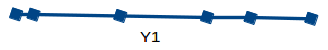

In [3]:
Image(filename='../datasets/Figs/straight_line.png')

Similarly, we can reduce p dimensions of the data into a subset of k dimensions (k<<n). This is called dimensionality reduction.

### 2. Why is Dimensionality Reduction required?

Here are some of the benefits of applying dimensionality reduction to a dataset:

+ Space required to store the data is reduced as the number of dimensions comes down
+ Less dimensions lead to less computation/training time
+ Some algorithms do not perform well when we have a large dimensions. So reducing these dimensions needs to happen for the algorithm to be useful
+ It takes care of multicollinearity by removing redundant features. For example, you have two variables – ‘time spent on treadmill in minutes’ and ‘calories burnt’. These variables are highly correlated as the more time you spend running on a treadmill, the more calories you will burn. Hence, there is no point in storing both as just one of them does what you require
+ It helps in visualizing data. As discussed earlier, it is very difficult to visualize data in higher dimensions so reducing our space to 2D or 3D may allow us to plot and observe patterns more clearly

#### 3. Common Dimensionality Reduction Techniques


We will be using [this](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/) dataset.

Dimensionality reduction can be done in two different ways:

+ Feature Selection - By only keeping the most relevant variables from the original dataset
+ Dimensionality Reduction - By finding a smaller set of new variables, each being a combination of the input variables, containing basically the same information as the input variables 

3.1 Missing Value Ratio

Suppose you’re given a dataset. What would be your first step? You would naturally want to explore the data first before building model. While exploring the data, you find that your dataset has some missing values. Now what? You will try to find out the reason for these missing values and then impute them or drop the variables entirely which have missing values (using appropriate methods).

What if we have too many missing values (say more than 50%)? Should we impute the missing values or drop the variable? I would prefer to drop the variable since it will not have much information. However, this isn’t set in stone. We can set a threshold value and if the percentage of missing values in any variable is more than that threshold, we will drop the variable.

In [5]:
df_train = pd.read_csv(os.path.join(datapath,'CSVs/BigMart_Train.csv'))
df_test = pd.read_csv(os.path.join(datapath,'CSVs/BigMart_Test.csv'))

In [7]:
# checking the percentage of missing values in each variable
df_train.isnull().sum()/len(df_train)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [13]:
# saving missing values in a variable
a = df_train.isnull().sum()/len(df_train)*100

# saving column names in a variable
variables = df_train.columns
variable = [ ]
for i in range(0,12):
    if a[i]<=20:   #setting the threshold as 20%
        variable.append(variables[i])

df_train[variable].isnull().sum()/len(df_train)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64